# PA Quantum Neuron

Build a classical neuron with a quantum circuit

In [1]:
from colorama import Fore, Back, Style 

import numpy as numpy
from pennylane import numpy as np
import pennylane as qml
from pennylane.optimize import NesterovMomentumOptimizer
from pennylane.math import requires_grad

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

from math import pi


# Quantum

In [2]:
max_iterations = 200
loop_count = 13

In [3]:

dev_1 = qml.device('default.qubit', wires=1)
dev_2 = qml.device('default.qubit', wires=1)
dev_3 = qml.device('default.qubit', wires=1)

## Classifier 1
weights_count = 3
init_weights_1 = (0.01 * np.random.randn(weights_count), 0.0)

print(init_weights_1)

@qml.qnode(dev_1)
def circuit_1(weights, data):
    qml.RY(data[0], wires=0) # input feature 1
    qml.RY(data[1], wires=0) # input feature 2
    qml.Rot(weights[0], weights[1], weights[2], wires=0) # weight 1
    
    return qml.expval(qml.PauliZ(0))

def vc_classifier_1(var, data):
    weights = var[0]
    bias = var[1]
    return circuit_1(weights, data) + bias


## Classifier 2
weights_count = 6
init_weights_2 = (0.01 * np.random.randn(weights_count), 0.0)

@qml.qnode(dev_2)
def circuit_2(weights, data):
    qml.RY(data[0], wires=0) # input feature 1
    qml.Rot(weights[0], weights[1], weights[2], wires=0) # weight 1
    
    qml.RY(data[1], wires=0) # input feature 2
    qml.Rot(weights[3], weights[4], weights[5], wires=0) # weight 2

    return qml.expval(qml.PauliZ(0))

def vc_classifier_2(var, data):
    weights = var[0]
    bias = var[1]
    return circuit_2(weights, data) + bias
  

## Classifier 3
weights_count = 6
init_weights_3 = (0.01 * np.random.randn(weights_count), 0.0)

@qml.qnode(dev_3)
def circuit_3(weights, data):
    qml.RY(data[0], wires=0) # input feature 1
    qml.Rot(weights[0], weights[1], weights[2], wires=0) # weight 1
    
    qml.RX(data[1], wires=0) # input feature 2
    qml.Rot(weights[3], weights[4], weights[5], wires=0) # weight 2
    
    return qml.expval(qml.PauliZ(0))

def vc_classifier_3(var, data):
    weights = var[0]
    bias = var[1]
    return circuit_3(weights, data) + bias


## generic
def square_loss(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        loss = loss + (l - p) ** 2
    loss = loss / len(labels)
    return loss

def cost(vc_classifier, weights, datas, labels):
    predictions = [vc_classifier(weights, f) for f in datas]
    return square_loss(labels, predictions)

def accuracy(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        if abs(l - p) < 1e-5:
            loss = loss + 1
    loss = loss / len(labels)
    return loss
  
def plot_costs(costs, num_layers):
  # plot costs
   fig, (ax1) = plt.subplots(1)
   fig.suptitle('Costs')
   ax1.plot(range(len(costs)), costs, label='Layers: {}'.format(num_layers))
   ax1.set_xlabel('iteration number')
   ax1.set_ylabel('cost objective function')
   ax1.legend(loc="upper right")
   plt.show()

# init weights
# var_init = (0.01 * np.random.randn(1, 2, 3), 0.0)


(tensor([-0.00652989, -0.00493965, -0.00099435], requires_grad=True), 0.0)


In [4]:
def vc_quantum(vc_classifier, init_weights, x_train, x_test, X, y_train, y_test, Y):
  opt = NesterovMomentumOptimizer(0.01)
  batch_size = 5
  var = init_weights
  iterations = max_iterations
  costs = np.zeros(iterations) 

  for it in range(iterations):

      # Update the weights by one optimizer step
      batch_index = np.random.randint(0, len(x_train), (batch_size,))
      feats_train_batch = x_train[batch_index]
      Y_train_batch = y_train[batch_index]
      var, stepCost = opt.step_and_cost(lambda v: cost(vc_classifier, v, feats_train_batch, Y_train_batch), var)
      # print("trained weights and bias (var):", var)

      # Compute predictions on train and validation set
      predictions_train = [np.sign(vc_classifier(var, f)) for f in x_train]
      predictions_val = [np.sign(vc_classifier(var, f)) for f in x_test]
      predictions_all = [np.sign(vc_classifier(var, f)) for f in X]

      # Compute accuracy on train and validation set
      acc_train = accuracy(y_train, predictions_train)
      acc_val = accuracy(y_test, predictions_val)
      acc_all = accuracy(Y, predictions_all)

      # gather informations for plotting
      costs[it] = cost(vc_classifier, var, X, Y)

      print(
          "Iter: {:5d} | Cost: {:0.7f} | Acc train: {:0.7f} | Acc val: {:0.7f} | Acc all: {:0.7f} "
          "".format(it + 1, costs[it], acc_train, acc_val, acc_all)
      )
  
  return [var, acc_val]

# plot costs
# plot_costs(costs, 0)

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.6983536 | Acc train: 0.5066667 | Acc val: 0.5600000 | Acc all: 0.5100000 
Iter:     2 | Cost: 1.6206770 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5100000 
Iter:     3 | Cost: 1.5433084 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5100000 
Iter:     4 | Cost: 1.4485397 | Acc train: 0.5466667 | Acc val: 0.5600000 | Acc all: 0.5300000 
Iter:     5 | Cost: 1.3238496 | Acc train: 0.5733333 | Acc val: 0.6400000 | Acc all: 0.5700000 
Iter:     6 | Cost: 1.2110725 | Acc train: 0.5733333 | Acc val: 0.6400000 | Acc all: 0.5700000 
Iter:     7 | Cost: 1.0900878 | Acc train: 0.5866667 | Acc val: 0.6800000 | Acc all: 0.5900000 
Iter:     8 | Cost: 0.9648573 | Acc train: 0.6266667 | Acc val: 0.7200000 | Acc all: 0.6300000 
Iter:     9 | Cost: 0.8316749 | Acc train: 0.6266667 | Acc val: 0.7200000 | Acc all: 0.6600000 
Iter:    10 | Cost: 0.7283100 | Acc train: 0.6800000 | Acc val: 0.8800000 | Acc all: 0.6900000 
Iter:    11 | Cost: 0.6760331 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.3892444 | Acc train: 0.5066667 | Acc val: 0.5600000 | Acc all: 0.5100000 
Iter:     2 | Cost: 1.3322694 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5200000 
Iter:     3 | Cost: 1.2621390 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5300000 
Iter:     4 | Cost: 1.1925717 | Acc train: 0.5600000 | Acc val: 0.5600000 | Acc all: 0.5400000 
Iter:     5 | Cost: 1.1241238 | Acc train: 0.5600000 | Acc val: 0.6000000 | Acc all: 0.5700000 
Iter:     6 | Cost: 1.0626081 | Acc train: 0.5866667 | Acc val: 0.6400000 | Acc all: 0.5700000 
Iter:     7 | Cost: 1.0086303 | Acc train: 0.6133333 | Acc val: 0.6400000 | Acc all: 0.6200000 
Iter:     8 | Cost: 0.9692583 | Acc train: 0.6266667 | Acc val: 0.6800000 | Acc all: 0.6200000 
Iter:     9 | Cost: 0.9309767 | Acc train: 0.6400000 | Acc val: 0.7200000 | Acc all: 0.6300000 
Iter:    10 | Cost: 0.9030257 | Acc train: 0.6533333 | Acc val: 0.7200000 | Acc all: 0.6400000 
Iter:    11 | Cost: 0.8757971 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.6528473 | Acc train: 0.4800000 | Acc val: 0.5600000 | Acc all: 0.5000000 
Iter:     2 | Cost: 1.5821332 | Acc train: 0.4800000 | Acc val: 0.6000000 | Acc all: 0.5000000 
Iter:     3 | Cost: 1.4860061 | Acc train: 0.4800000 | Acc val: 0.6000000 | Acc all: 0.5000000 
Iter:     4 | Cost: 1.3828154 | Acc train: 0.4800000 | Acc val: 0.6000000 | Acc all: 0.5100000 
Iter:     5 | Cost: 1.2829292 | Acc train: 0.4933333 | Acc val: 0.6000000 | Acc all: 0.5000000 
Iter:     6 | Cost: 1.2077868 | Acc train: 0.4800000 | Acc val: 0.6000000 | Acc all: 0.5100000 
Iter:     7 | Cost: 1.1328740 | Acc train: 0.5066667 | Acc val: 0.6000000 | Acc all: 0.5300000 
Iter:     8 | Cost: 1.0705267 | Acc train: 0.5066667 | Acc val: 0.5600000 | Acc all: 0.5100000 
Iter:     9 | Cost: 1.0251551 | Acc train: 0.4933333 | Acc val: 0.6000000 | Acc all: 0.4600000 
Iter:    10 | Cost: 1.0004494 | Acc train: 0.5600000 | Acc val: 0.6000000 | Acc all: 0.5200000 
Iter:    11 | Cost: 0.9919612 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.6948696 | Acc train: 0.5066667 | Acc val: 0.5200000 | Acc all: 0.5000000 
Iter:     2 | Cost: 1.6313052 | Acc train: 0.5066667 | Acc val: 0.5200000 | Acc all: 0.5100000 
Iter:     3 | Cost: 1.5674865 | Acc train: 0.5066667 | Acc val: 0.5200000 | Acc all: 0.5100000 
Iter:     4 | Cost: 1.4737755 | Acc train: 0.5333333 | Acc val: 0.5600000 | Acc all: 0.5300000 
Iter:     5 | Cost: 1.3454306 | Acc train: 0.5333333 | Acc val: 0.5600000 | Acc all: 0.5400000 
Iter:     6 | Cost: 1.2293217 | Acc train: 0.5733333 | Acc val: 0.6400000 | Acc all: 0.5600000 
Iter:     7 | Cost: 1.1255179 | Acc train: 0.5866667 | Acc val: 0.6400000 | Acc all: 0.5700000 
Iter:     8 | Cost: 1.0325425 | Acc train: 0.6000000 | Acc val: 0.7200000 | Acc all: 0.6000000 
Iter:     9 | Cost: 0.9324355 | Acc train: 0.6400000 | Acc val: 0.7200000 | Acc all: 0.6400000 
Iter:    10 | Cost: 0.8321102 | Acc train: 0.6400000 | Acc val: 0.7600000 | Acc all: 0.6600000 
Iter:    11 | Cost: 0.7713792 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.4146887 | Acc train: 0.4933333 | Acc val: 0.5600000 | Acc all: 0.5000000 
Iter:     2 | Cost: 1.3956531 | Acc train: 0.5066667 | Acc val: 0.5600000 | Acc all: 0.5000000 
Iter:     3 | Cost: 1.3505099 | Acc train: 0.5066667 | Acc val: 0.5600000 | Acc all: 0.5100000 
Iter:     4 | Cost: 1.2793068 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5300000 
Iter:     5 | Cost: 1.2058570 | Acc train: 0.5333333 | Acc val: 0.6000000 | Acc all: 0.5400000 
Iter:     6 | Cost: 1.1281877 | Acc train: 0.5600000 | Acc val: 0.6000000 | Acc all: 0.5700000 
Iter:     7 | Cost: 1.0502241 | Acc train: 0.5866667 | Acc val: 0.6400000 | Acc all: 0.5900000 
Iter:     8 | Cost: 0.9916320 | Acc train: 0.6133333 | Acc val: 0.6400000 | Acc all: 0.6200000 
Iter:     9 | Cost: 0.9419324 | Acc train: 0.6400000 | Acc val: 0.7200000 | Acc all: 0.6300000 
Iter:    10 | Cost: 0.9017848 | Acc train: 0.6533333 | Acc val: 0.7200000 | Acc all: 0.6500000 
Iter:    11 | Cost: 0.8727432 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.6760858 | Acc train: 0.4800000 | Acc val: 0.5600000 | Acc all: 0.5000000 
Iter:     2 | Cost: 1.6024688 | Acc train: 0.4800000 | Acc val: 0.6000000 | Acc all: 0.5000000 
Iter:     3 | Cost: 1.5134058 | Acc train: 0.4800000 | Acc val: 0.6000000 | Acc all: 0.5000000 
Iter:     4 | Cost: 1.4386727 | Acc train: 0.4800000 | Acc val: 0.6000000 | Acc all: 0.5000000 
Iter:     5 | Cost: 1.3764402 | Acc train: 0.4800000 | Acc val: 0.6000000 | Acc all: 0.5000000 
Iter:     6 | Cost: 1.3212707 | Acc train: 0.4933333 | Acc val: 0.6000000 | Acc all: 0.5100000 
Iter:     7 | Cost: 1.2700143 | Acc train: 0.4933333 | Acc val: 0.6000000 | Acc all: 0.5000000 
Iter:     8 | Cost: 1.2046454 | Acc train: 0.5066667 | Acc val: 0.6000000 | Acc all: 0.5300000 
Iter:     9 | Cost: 1.1431744 | Acc train: 0.5066667 | Acc val: 0.6000000 | Acc all: 0.5300000 
Iter:    10 | Cost: 1.0989295 | Acc train: 0.5200000 | Acc val: 0.6000000 | Acc all: 0.5200000 
Iter:    11 | Cost: 1.0671320 | Acc trai

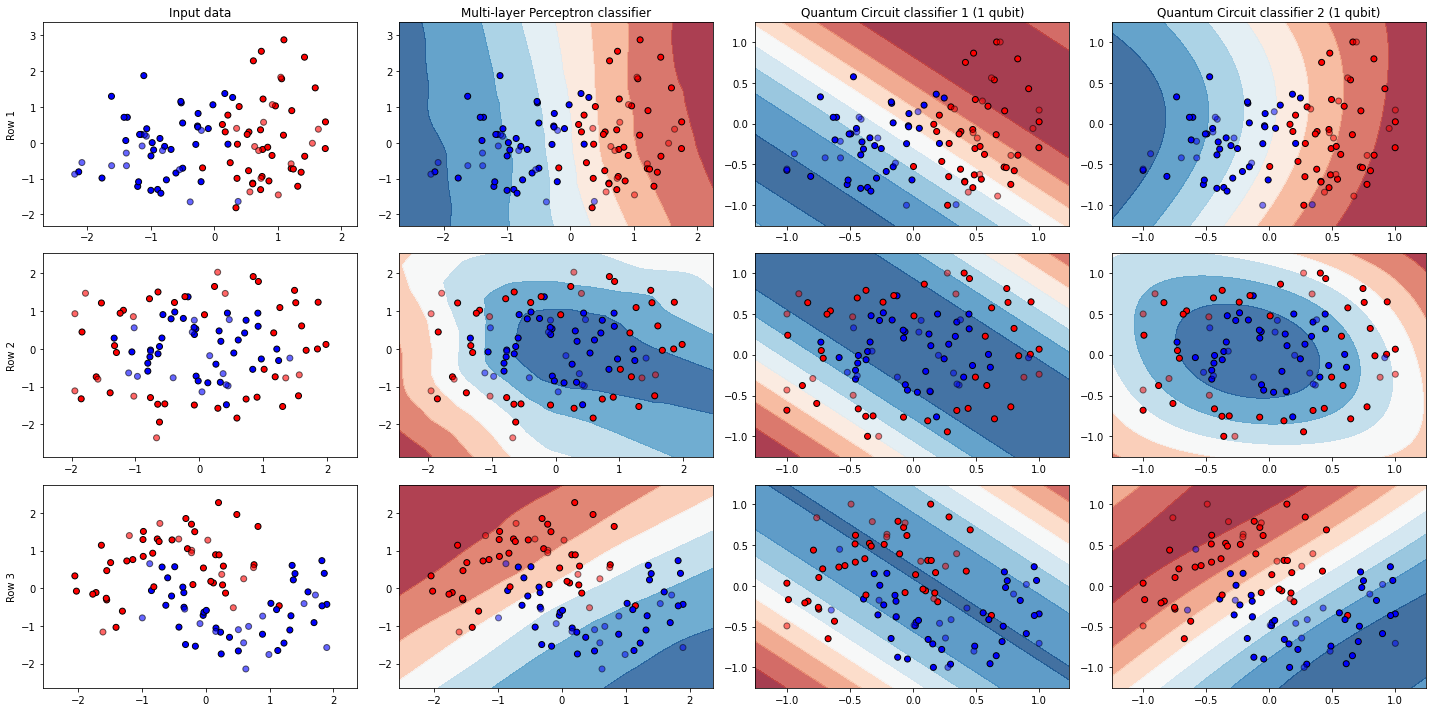

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.7043248 | Acc train: 0.5066667 | Acc val: 0.5200000 | Acc all: 0.5000000 
Iter:     2 | Cost: 1.5995332 | Acc train: 0.5066667 | Acc val: 0.5200000 | Acc all: 0.5000000 
Iter:     3 | Cost: 1.4858757 | Acc train: 0.5066667 | Acc val: 0.5200000 | Acc all: 0.5000000 
Iter:     4 | Cost: 1.3653330 | Acc train: 0.5333333 | Acc val: 0.5200000 | Acc all: 0.5200000 
Iter:     5 | Cost: 1.2366647 | Acc train: 0.5600000 | Acc val: 0.6000000 | Acc all: 0.5500000 
Iter:     6 | Cost: 1.1010655 | Acc train: 0.5733333 | Acc val: 0.6000000 | Acc all: 0.5600000 
Iter:     7 | Cost: 0.9885867 | Acc train: 0.6133333 | Acc val: 0.6800000 | Acc all: 0.6100000 
Iter:     8 | Cost: 0.8947272 | Acc train: 0.6266667 | Acc val: 0.6800000 | Acc all: 0.6300000 
Iter:     9 | Cost: 0.8241095 | Acc train: 0.6400000 | Acc val: 0.7200000 | Acc all: 0.6500000 
Iter:    10 | Cost: 0.7688199 | Acc train: 0.6666667 | Acc val: 0.8400000 | Acc all: 0.6700000 
Iter:    11 | Cost: 0.7410020 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.3963748 | Acc train: 0.4933333 | Acc val: 0.5600000 | Acc all: 0.5000000 
Iter:     2 | Cost: 1.3672589 | Acc train: 0.4933333 | Acc val: 0.5600000 | Acc all: 0.5100000 
Iter:     3 | Cost: 1.3044740 | Acc train: 0.4933333 | Acc val: 0.6000000 | Acc all: 0.5200000 
Iter:     4 | Cost: 1.2293991 | Acc train: 0.5333333 | Acc val: 0.6000000 | Acc all: 0.5400000 
Iter:     5 | Cost: 1.1453463 | Acc train: 0.5600000 | Acc val: 0.6400000 | Acc all: 0.5500000 
Iter:     6 | Cost: 1.0786853 | Acc train: 0.5600000 | Acc val: 0.6400000 | Acc all: 0.5600000 
Iter:     7 | Cost: 1.0058348 | Acc train: 0.6266667 | Acc val: 0.6800000 | Acc all: 0.6100000 
Iter:     8 | Cost: 0.9421576 | Acc train: 0.6400000 | Acc val: 0.7200000 | Acc all: 0.6300000 
Iter:     9 | Cost: 0.8952714 | Acc train: 0.6533333 | Acc val: 0.7600000 | Acc all: 0.6600000 
Iter:    10 | Cost: 0.8585078 | Acc train: 0.6800000 | Acc val: 0.7600000 | Acc all: 0.7000000 
Iter:    11 | Cost: 0.8340495 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.6614601 | Acc train: 0.4800000 | Acc val: 0.5600000 | Acc all: 0.5000000 
Iter:     2 | Cost: 1.5985607 | Acc train: 0.4800000 | Acc val: 0.6000000 | Acc all: 0.5000000 
Iter:     3 | Cost: 1.5260752 | Acc train: 0.4800000 | Acc val: 0.6000000 | Acc all: 0.5000000 
Iter:     4 | Cost: 1.4402847 | Acc train: 0.4800000 | Acc val: 0.6000000 | Acc all: 0.5000000 
Iter:     5 | Cost: 1.3468049 | Acc train: 0.4933333 | Acc val: 0.6000000 | Acc all: 0.5100000 
Iter:     6 | Cost: 1.2486887 | Acc train: 0.4800000 | Acc val: 0.6000000 | Acc all: 0.5000000 
Iter:     7 | Cost: 1.1635169 | Acc train: 0.5200000 | Acc val: 0.6000000 | Acc all: 0.5200000 
Iter:     8 | Cost: 1.0991233 | Acc train: 0.5200000 | Acc val: 0.6000000 | Acc all: 0.5200000 
Iter:     9 | Cost: 1.0514264 | Acc train: 0.5066667 | Acc val: 0.5600000 | Acc all: 0.5100000 
Iter:    10 | Cost: 1.0175774 | Acc train: 0.5466667 | Acc val: 0.6000000 | Acc all: 0.4800000 
Iter:    11 | Cost: 0.9955480 | Acc trai

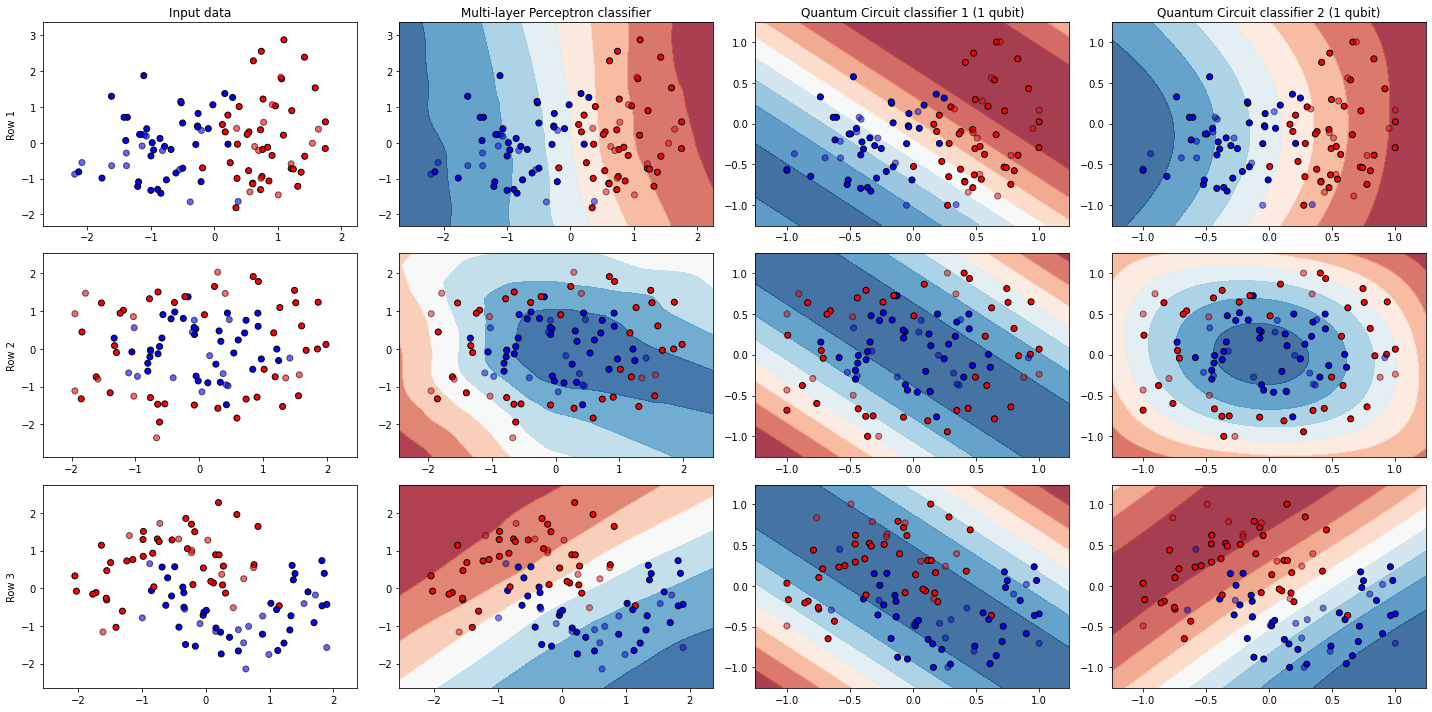

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.7098285 | Acc train: 0.5066667 | Acc val: 0.5200000 | Acc all: 0.5100000 
Iter:     2 | Cost: 1.6245246 | Acc train: 0.5066667 | Acc val: 0.5600000 | Acc all: 0.5100000 
Iter:     3 | Cost: 1.5169112 | Acc train: 0.5066667 | Acc val: 0.5200000 | Acc all: 0.5000000 
Iter:     4 | Cost: 1.3979601 | Acc train: 0.5333333 | Acc val: 0.5200000 | Acc all: 0.5200000 
Iter:     5 | Cost: 1.2581239 | Acc train: 0.5600000 | Acc val: 0.6000000 | Acc all: 0.5600000 
Iter:     6 | Cost: 1.1059339 | Acc train: 0.5733333 | Acc val: 0.6400000 | Acc all: 0.5700000 
Iter:     7 | Cost: 0.9666182 | Acc train: 0.6133333 | Acc val: 0.7200000 | Acc all: 0.6200000 
Iter:     8 | Cost: 0.8657061 | Acc train: 0.6266667 | Acc val: 0.7200000 | Acc all: 0.6200000 
Iter:     9 | Cost: 0.7993177 | Acc train: 0.6533333 | Acc val: 0.7600000 | Acc all: 0.6700000 
Iter:    10 | Cost: 0.7521942 | Acc train: 0.6800000 | Acc val: 0.8800000 | Acc all: 0.6900000 
Iter:    11 | Cost: 0.7199913 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.3917279 | Acc train: 0.5066667 | Acc val: 0.5600000 | Acc all: 0.5000000 
Iter:     2 | Cost: 1.3484688 | Acc train: 0.5066667 | Acc val: 0.5600000 | Acc all: 0.5100000 
Iter:     3 | Cost: 1.2845100 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5300000 
Iter:     4 | Cost: 1.2161003 | Acc train: 0.5333333 | Acc val: 0.5600000 | Acc all: 0.5300000 
Iter:     5 | Cost: 1.1497195 | Acc train: 0.5600000 | Acc val: 0.6000000 | Acc all: 0.5700000 
Iter:     6 | Cost: 1.0891448 | Acc train: 0.5600000 | Acc val: 0.6400000 | Acc all: 0.5700000 
Iter:     7 | Cost: 1.0462272 | Acc train: 0.5866667 | Acc val: 0.6400000 | Acc all: 0.5900000 
Iter:     8 | Cost: 1.0069002 | Acc train: 0.6000000 | Acc val: 0.6400000 | Acc all: 0.5900000 
Iter:     9 | Cost: 0.9650527 | Acc train: 0.6266667 | Acc val: 0.6800000 | Acc all: 0.6200000 
Iter:    10 | Cost: 0.9293737 | Acc train: 0.6400000 | Acc val: 0.7200000 | Acc all: 0.6300000 
Iter:    11 | Cost: 0.8970646 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.6545822 | Acc train: 0.4800000 | Acc val: 0.6000000 | Acc all: 0.5000000 
Iter:     2 | Cost: 1.5757116 | Acc train: 0.4800000 | Acc val: 0.6000000 | Acc all: 0.5000000 
Iter:     3 | Cost: 1.4851114 | Acc train: 0.4933333 | Acc val: 0.6000000 | Acc all: 0.5100000 
Iter:     4 | Cost: 1.3972041 | Acc train: 0.4933333 | Acc val: 0.6000000 | Acc all: 0.5100000 
Iter:     5 | Cost: 1.3030348 | Acc train: 0.5066667 | Acc val: 0.6000000 | Acc all: 0.5200000 
Iter:     6 | Cost: 1.2336551 | Acc train: 0.5733333 | Acc val: 0.6000000 | Acc all: 0.5300000 
Iter:     7 | Cost: 1.1702308 | Acc train: 0.5600000 | Acc val: 0.5600000 | Acc all: 0.5600000 
Iter:     8 | Cost: 1.1186555 | Acc train: 0.5466667 | Acc val: 0.5600000 | Acc all: 0.5600000 
Iter:     9 | Cost: 1.0779391 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5700000 
Iter:    10 | Cost: 1.0514720 | Acc train: 0.5466667 | Acc val: 0.5200000 | Acc all: 0.5400000 
Iter:    11 | Cost: 1.0348417 | Acc trai

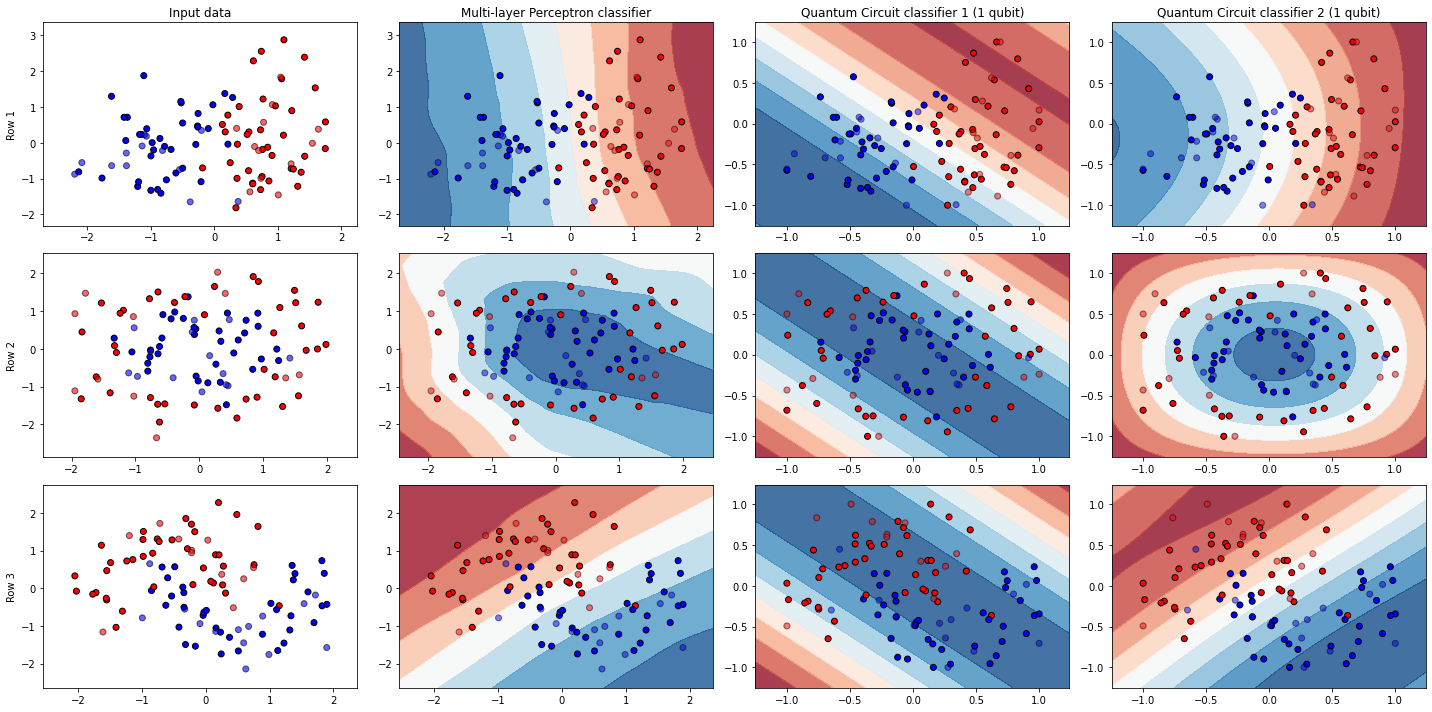

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.7084887 | Acc train: 0.5066667 | Acc val: 0.5200000 | Acc all: 0.5000000 
Iter:     2 | Cost: 1.6421209 | Acc train: 0.5066667 | Acc val: 0.5200000 | Acc all: 0.5000000 
Iter:     3 | Cost: 1.5405029 | Acc train: 0.5066667 | Acc val: 0.5200000 | Acc all: 0.5000000 
Iter:     4 | Cost: 1.4435075 | Acc train: 0.5333333 | Acc val: 0.5200000 | Acc all: 0.5200000 
Iter:     5 | Cost: 1.3294862 | Acc train: 0.5333333 | Acc val: 0.5200000 | Acc all: 0.5300000 
Iter:     6 | Cost: 1.2127350 | Acc train: 0.5600000 | Acc val: 0.6000000 | Acc all: 0.5500000 
Iter:     7 | Cost: 1.1011013 | Acc train: 0.5733333 | Acc val: 0.6000000 | Acc all: 0.5600000 
Iter:     8 | Cost: 0.9851850 | Acc train: 0.6133333 | Acc val: 0.6800000 | Acc all: 0.6200000 
Iter:     9 | Cost: 0.8941408 | Acc train: 0.6266667 | Acc val: 0.7200000 | Acc all: 0.6400000 
Iter:    10 | Cost: 0.8238580 | Acc train: 0.6400000 | Acc val: 0.7600000 | Acc all: 0.6500000 
Iter:    11 | Cost: 0.7706983 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.3912597 | Acc train: 0.5066667 | Acc val: 0.5600000 | Acc all: 0.5100000 
Iter:     2 | Cost: 1.3452508 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5200000 
Iter:     3 | Cost: 1.2748439 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5200000 
Iter:     4 | Cost: 1.2056802 | Acc train: 0.5333333 | Acc val: 0.6000000 | Acc all: 0.5400000 
Iter:     5 | Cost: 1.1357063 | Acc train: 0.5866667 | Acc val: 0.6000000 | Acc all: 0.5600000 
Iter:     6 | Cost: 1.0579772 | Acc train: 0.5866667 | Acc val: 0.6000000 | Acc all: 0.5800000 
Iter:     7 | Cost: 0.9894772 | Acc train: 0.6000000 | Acc val: 0.6800000 | Acc all: 0.5800000 
Iter:     8 | Cost: 0.9346836 | Acc train: 0.6400000 | Acc val: 0.6800000 | Acc all: 0.6400000 
Iter:     9 | Cost: 0.8886682 | Acc train: 0.6800000 | Acc val: 0.7600000 | Acc all: 0.6700000 
Iter:    10 | Cost: 0.8562563 | Acc train: 0.6800000 | Acc val: 0.8000000 | Acc all: 0.7000000 
Iter:    11 | Cost: 0.8315459 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.7001710 | Acc train: 0.4800000 | Acc val: 0.5600000 | Acc all: 0.5000000 
Iter:     2 | Cost: 1.6589307 | Acc train: 0.4800000 | Acc val: 0.5600000 | Acc all: 0.5000000 
Iter:     3 | Cost: 1.5959995 | Acc train: 0.4800000 | Acc val: 0.6000000 | Acc all: 0.5000000 
Iter:     4 | Cost: 1.4926665 | Acc train: 0.4800000 | Acc val: 0.6000000 | Acc all: 0.5000000 
Iter:     5 | Cost: 1.4006099 | Acc train: 0.4933333 | Acc val: 0.6000000 | Acc all: 0.5100000 
Iter:     6 | Cost: 1.3168086 | Acc train: 0.4933333 | Acc val: 0.6000000 | Acc all: 0.5100000 
Iter:     7 | Cost: 1.2336775 | Acc train: 0.5066667 | Acc val: 0.6000000 | Acc all: 0.5200000 
Iter:     8 | Cost: 1.1657850 | Acc train: 0.5200000 | Acc val: 0.6000000 | Acc all: 0.5100000 
Iter:     9 | Cost: 1.1025553 | Acc train: 0.5866667 | Acc val: 0.6000000 | Acc all: 0.5400000 
Iter:    10 | Cost: 1.0565425 | Acc train: 0.5733333 | Acc val: 0.5600000 | Acc all: 0.5900000 
Iter:    11 | Cost: 1.0222397 | Acc trai

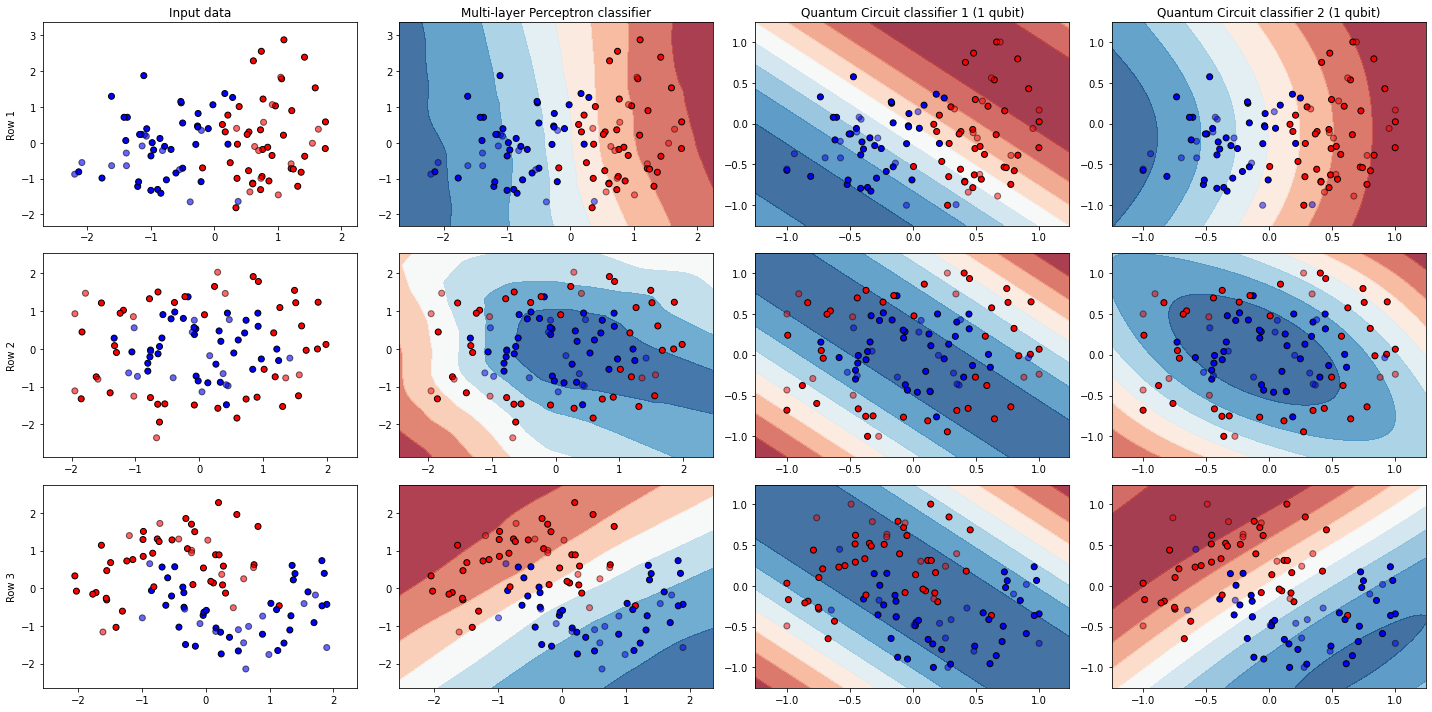

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.7402906 | Acc train: 0.5066667 | Acc val: 0.5200000 | Acc all: 0.5100000 
Iter:     2 | Cost: 1.7032834 | Acc train: 0.5066667 | Acc val: 0.5600000 | Acc all: 0.5100000 
Iter:     3 | Cost: 1.6721182 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5100000 
Iter:     4 | Cost: 1.6196542 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5100000 
Iter:     5 | Cost: 1.5677803 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5200000 
Iter:     6 | Cost: 1.4961865 | Acc train: 0.5466667 | Acc val: 0.5600000 | Acc all: 0.5400000 
Iter:     7 | Cost: 1.4020907 | Acc train: 0.5466667 | Acc val: 0.5600000 | Acc all: 0.5400000 
Iter:     8 | Cost: 1.2653833 | Acc train: 0.5733333 | Acc val: 0.6400000 | Acc all: 0.5700000 
Iter:     9 | Cost: 1.1342556 | Acc train: 0.5866667 | Acc val: 0.6400000 | Acc all: 0.5800000 
Iter:    10 | Cost: 0.9890647 | Acc train: 0.6266667 | Acc val: 0.7200000 | Acc all: 0.6300000 
Iter:    11 | Cost: 0.8658862 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.4021874 | Acc train: 0.4933333 | Acc val: 0.5600000 | Acc all: 0.5000000 
Iter:     2 | Cost: 1.3618128 | Acc train: 0.5066667 | Acc val: 0.5600000 | Acc all: 0.5100000 
Iter:     3 | Cost: 1.3037612 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5200000 
Iter:     4 | Cost: 1.2394275 | Acc train: 0.5200000 | Acc val: 0.6000000 | Acc all: 0.5400000 
Iter:     5 | Cost: 1.1769412 | Acc train: 0.5466667 | Acc val: 0.6000000 | Acc all: 0.5400000 
Iter:     6 | Cost: 1.1122691 | Acc train: 0.5866667 | Acc val: 0.6000000 | Acc all: 0.5800000 
Iter:     7 | Cost: 1.0607817 | Acc train: 0.5866667 | Acc val: 0.6000000 | Acc all: 0.5800000 
Iter:     8 | Cost: 1.0061348 | Acc train: 0.6000000 | Acc val: 0.6800000 | Acc all: 0.5800000 
Iter:     9 | Cost: 0.9497867 | Acc train: 0.6133333 | Acc val: 0.6800000 | Acc all: 0.6200000 
Iter:    10 | Cost: 0.9056599 | Acc train: 0.6666667 | Acc val: 0.7200000 | Acc all: 0.6600000 
Iter:    11 | Cost: 0.8731846 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.6728776 | Acc train: 0.4800000 | Acc val: 0.5600000 | Acc all: 0.5000000 
Iter:     2 | Cost: 1.6358197 | Acc train: 0.4800000 | Acc val: 0.6000000 | Acc all: 0.5000000 
Iter:     3 | Cost: 1.5900969 | Acc train: 0.4800000 | Acc val: 0.6000000 | Acc all: 0.5000000 
Iter:     4 | Cost: 1.5483538 | Acc train: 0.4800000 | Acc val: 0.6000000 | Acc all: 0.5000000 
Iter:     5 | Cost: 1.5108920 | Acc train: 0.4800000 | Acc val: 0.6000000 | Acc all: 0.5000000 
Iter:     6 | Cost: 1.4770035 | Acc train: 0.4800000 | Acc val: 0.6000000 | Acc all: 0.5000000 
Iter:     7 | Cost: 1.4235809 | Acc train: 0.4800000 | Acc val: 0.6000000 | Acc all: 0.5100000 
Iter:     8 | Cost: 1.3900891 | Acc train: 0.4933333 | Acc val: 0.6000000 | Acc all: 0.5100000 
Iter:     9 | Cost: 1.3468007 | Acc train: 0.4933333 | Acc val: 0.6000000 | Acc all: 0.5100000 
Iter:    10 | Cost: 1.3008314 | Acc train: 0.4933333 | Acc val: 0.6000000 | Acc all: 0.5100000 
Iter:    11 | Cost: 1.2520236 | Acc trai

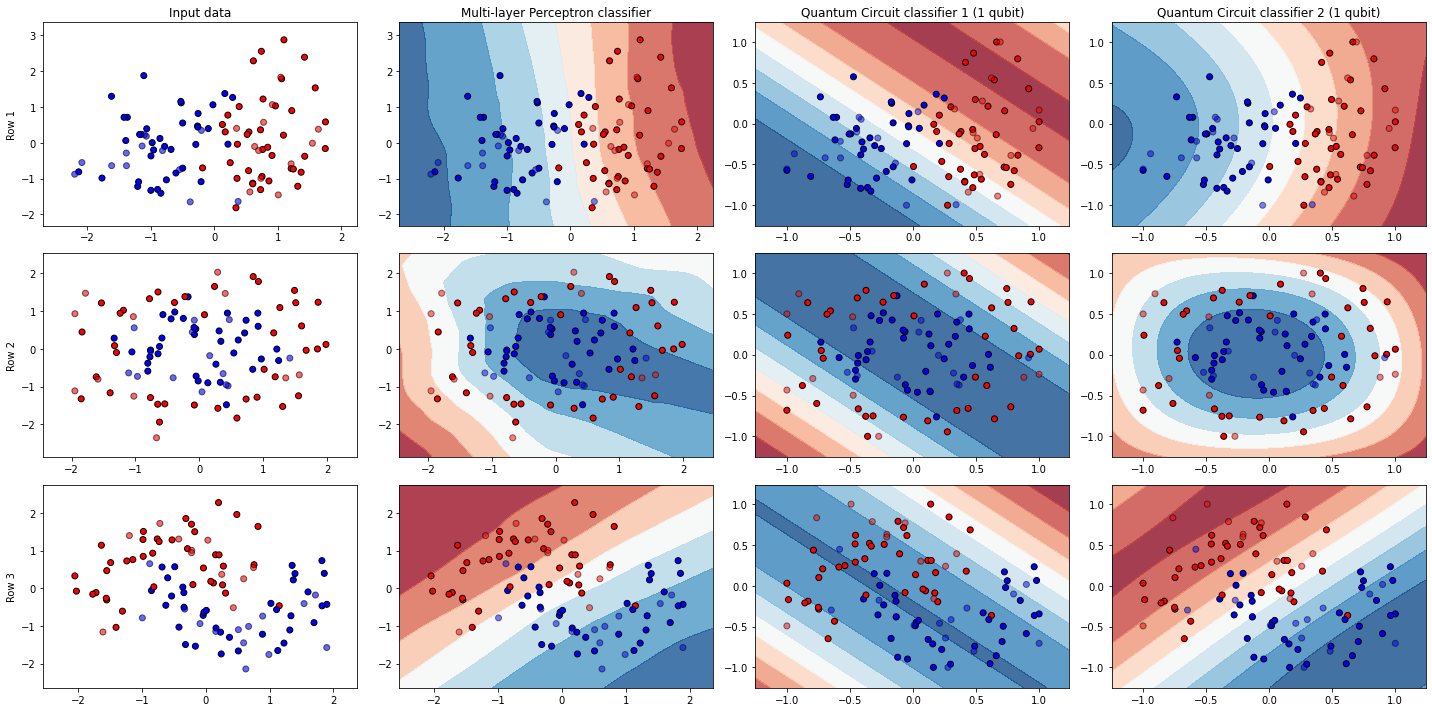

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.6980290 | Acc train: 0.5066667 | Acc val: 0.5200000 | Acc all: 0.5000000 
Iter:     2 | Cost: 1.6418357 | Acc train: 0.5066667 | Acc val: 0.5200000 | Acc all: 0.5000000 
Iter:     3 | Cost: 1.5511126 | Acc train: 0.5066667 | Acc val: 0.5200000 | Acc all: 0.5100000 
Iter:     4 | Cost: 1.4753219 | Acc train: 0.5466667 | Acc val: 0.5600000 | Acc all: 0.5300000 
Iter:     5 | Cost: 1.3918750 | Acc train: 0.5466667 | Acc val: 0.5600000 | Acc all: 0.5300000 
Iter:     6 | Cost: 1.3015324 | Acc train: 0.5733333 | Acc val: 0.6400000 | Acc all: 0.5700000 
Iter:     7 | Cost: 1.1791348 | Acc train: 0.5866667 | Acc val: 0.6400000 | Acc all: 0.5800000 
Iter:     8 | Cost: 1.0621428 | Acc train: 0.6000000 | Acc val: 0.6800000 | Acc all: 0.6000000 
Iter:     9 | Cost: 0.9419278 | Acc train: 0.6400000 | Acc val: 0.7200000 | Acc all: 0.6400000 
Iter:    10 | Cost: 0.8334078 | Acc train: 0.6266667 | Acc val: 0.7200000 | Acc all: 0.6600000 
Iter:    11 | Cost: 0.7494981 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.3962438 | Acc train: 0.5066667 | Acc val: 0.5600000 | Acc all: 0.5100000 
Iter:     2 | Cost: 1.3475688 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5200000 
Iter:     3 | Cost: 1.2889364 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5200000 
Iter:     4 | Cost: 1.2257743 | Acc train: 0.5600000 | Acc val: 0.5600000 | Acc all: 0.5300000 
Iter:     5 | Cost: 1.1450630 | Acc train: 0.5600000 | Acc val: 0.5600000 | Acc all: 0.5600000 
Iter:     6 | Cost: 1.0667812 | Acc train: 0.5733333 | Acc val: 0.6400000 | Acc all: 0.5800000 
Iter:     7 | Cost: 0.9991620 | Acc train: 0.6133333 | Acc val: 0.6400000 | Acc all: 0.6200000 
Iter:     8 | Cost: 0.9388879 | Acc train: 0.6400000 | Acc val: 0.7200000 | Acc all: 0.6300000 
Iter:     9 | Cost: 0.8923285 | Acc train: 0.6533333 | Acc val: 0.7200000 | Acc all: 0.6500000 
Iter:    10 | Cost: 0.8605330 | Acc train: 0.7066667 | Acc val: 0.6800000 | Acc all: 0.6900000 
Iter:    11 | Cost: 0.8417370 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.6908298 | Acc train: 0.4800000 | Acc val: 0.5600000 | Acc all: 0.5000000 
Iter:     2 | Cost: 1.6558772 | Acc train: 0.4800000 | Acc val: 0.5600000 | Acc all: 0.5000000 
Iter:     3 | Cost: 1.6232738 | Acc train: 0.4800000 | Acc val: 0.5600000 | Acc all: 0.5000000 
Iter:     4 | Cost: 1.5658491 | Acc train: 0.4800000 | Acc val: 0.5600000 | Acc all: 0.5000000 
Iter:     5 | Cost: 1.4808311 | Acc train: 0.4800000 | Acc val: 0.6000000 | Acc all: 0.5000000 
Iter:     6 | Cost: 1.4026115 | Acc train: 0.4800000 | Acc val: 0.6000000 | Acc all: 0.5000000 
Iter:     7 | Cost: 1.3279482 | Acc train: 0.4800000 | Acc val: 0.6000000 | Acc all: 0.5100000 
Iter:     8 | Cost: 1.2640122 | Acc train: 0.4933333 | Acc val: 0.6000000 | Acc all: 0.5000000 
Iter:     9 | Cost: 1.2062633 | Acc train: 0.4800000 | Acc val: 0.6000000 | Acc all: 0.5000000 
Iter:    10 | Cost: 1.1563587 | Acc train: 0.5333333 | Acc val: 0.6000000 | Acc all: 0.5300000 
Iter:    11 | Cost: 1.1100317 | Acc trai

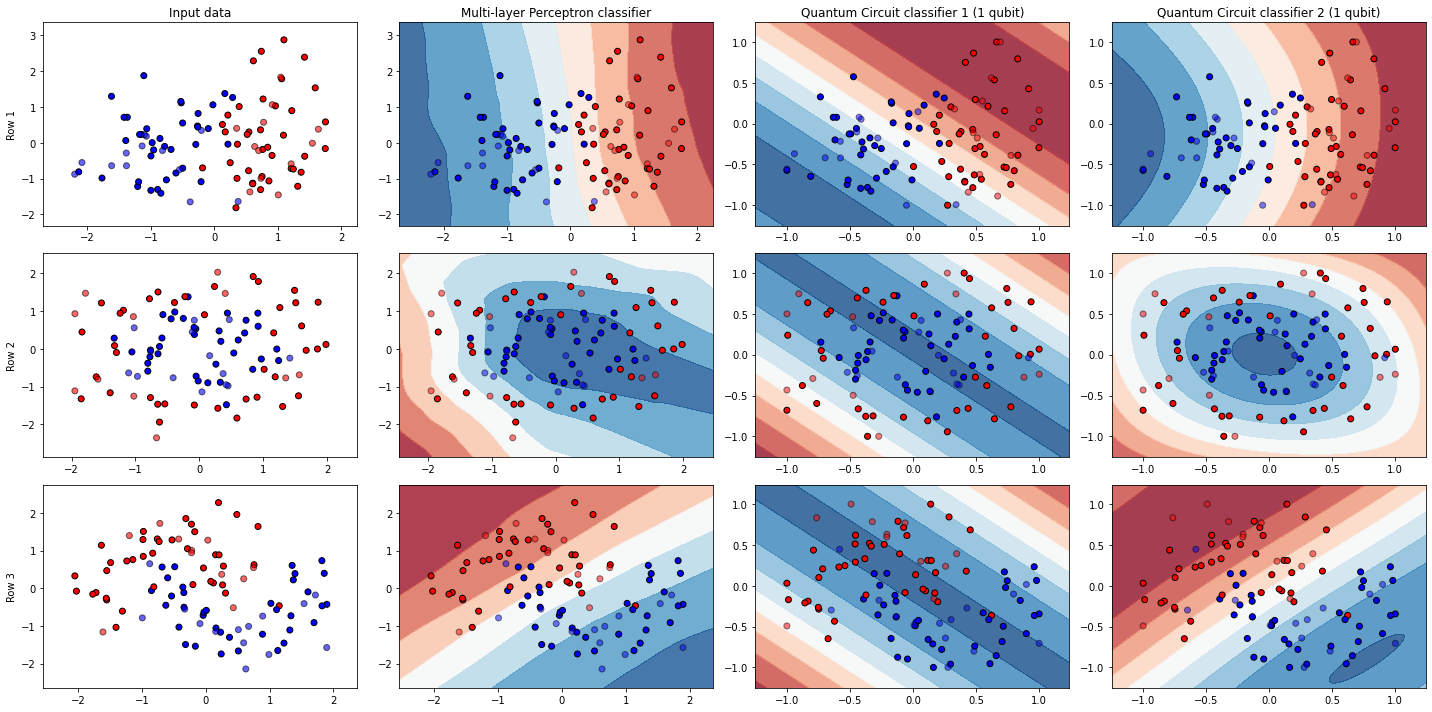

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.7487159 | Acc train: 0.5066667 | Acc val: 0.5200000 | Acc all: 0.5000000 
Iter:     2 | Cost: 1.7094657 | Acc train: 0.5066667 | Acc val: 0.5200000 | Acc all: 0.5000000 
Iter:     3 | Cost: 1.6248223 | Acc train: 0.5066667 | Acc val: 0.5200000 | Acc all: 0.5000000 
Iter:     4 | Cost: 1.5249546 | Acc train: 0.5066667 | Acc val: 0.5200000 | Acc all: 0.5000000 
Iter:     5 | Cost: 1.3951778 | Acc train: 0.5333333 | Acc val: 0.5200000 | Acc all: 0.5200000 
Iter:     6 | Cost: 1.2638775 | Acc train: 0.5600000 | Acc val: 0.6000000 | Acc all: 0.5500000 
Iter:     7 | Cost: 1.1410272 | Acc train: 0.5733333 | Acc val: 0.6000000 | Acc all: 0.5600000 
Iter:     8 | Cost: 1.0249010 | Acc train: 0.6000000 | Acc val: 0.6800000 | Acc all: 0.6000000 
Iter:     9 | Cost: 0.9382897 | Acc train: 0.6266667 | Acc val: 0.6800000 | Acc all: 0.6200000 
Iter:    10 | Cost: 0.8608794 | Acc train: 0.6133333 | Acc val: 0.6800000 | Acc all: 0.6300000 
Iter:    11 | Cost: 0.7941557 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.3944552 | Acc train: 0.4933333 | Acc val: 0.5600000 | Acc all: 0.5000000 
Iter:     2 | Cost: 1.3288128 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5200000 
Iter:     3 | Cost: 1.2547035 | Acc train: 0.5200000 | Acc val: 0.6000000 | Acc all: 0.5400000 
Iter:     4 | Cost: 1.1902872 | Acc train: 0.5466667 | Acc val: 0.6000000 | Acc all: 0.5400000 
Iter:     5 | Cost: 1.1347174 | Acc train: 0.5733333 | Acc val: 0.6000000 | Acc all: 0.5600000 
Iter:     6 | Cost: 1.0675241 | Acc train: 0.5866667 | Acc val: 0.6000000 | Acc all: 0.5800000 
Iter:     7 | Cost: 1.0130014 | Acc train: 0.6000000 | Acc val: 0.6800000 | Acc all: 0.5900000 
Iter:     8 | Cost: 0.9672600 | Acc train: 0.6266667 | Acc val: 0.6800000 | Acc all: 0.6200000 
Iter:     9 | Cost: 0.9199689 | Acc train: 0.6400000 | Acc val: 0.7200000 | Acc all: 0.6400000 
Iter:    10 | Cost: 0.8861412 | Acc train: 0.6666667 | Acc val: 0.7200000 | Acc all: 0.6700000 
Iter:    11 | Cost: 0.8659045 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.6875629 | Acc train: 0.4800000 | Acc val: 0.5600000 | Acc all: 0.5000000 
Iter:     2 | Cost: 1.6571859 | Acc train: 0.4800000 | Acc val: 0.5600000 | Acc all: 0.5000000 
Iter:     3 | Cost: 1.5945696 | Acc train: 0.4800000 | Acc val: 0.6000000 | Acc all: 0.5000000 
Iter:     4 | Cost: 1.5282493 | Acc train: 0.4800000 | Acc val: 0.6000000 | Acc all: 0.5000000 
Iter:     5 | Cost: 1.4490512 | Acc train: 0.4800000 | Acc val: 0.6000000 | Acc all: 0.5000000 
Iter:     6 | Cost: 1.3577080 | Acc train: 0.4933333 | Acc val: 0.6000000 | Acc all: 0.5100000 
Iter:     7 | Cost: 1.2727769 | Acc train: 0.5066667 | Acc val: 0.6000000 | Acc all: 0.5200000 
Iter:     8 | Cost: 1.2006959 | Acc train: 0.5333333 | Acc val: 0.6000000 | Acc all: 0.5300000 
Iter:     9 | Cost: 1.1268357 | Acc train: 0.5466667 | Acc val: 0.5600000 | Acc all: 0.5600000 
Iter:    10 | Cost: 1.0775102 | Acc train: 0.5600000 | Acc val: 0.5600000 | Acc all: 0.5800000 
Iter:    11 | Cost: 1.0462777 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.7486181 | Acc train: 0.5066667 | Acc val: 0.5200000 | Acc all: 0.5100000 
Iter:     2 | Cost: 1.6789447 | Acc train: 0.5066667 | Acc val: 0.5200000 | Acc all: 0.5000000 
Iter:     3 | Cost: 1.5977115 | Acc train: 0.5066667 | Acc val: 0.5200000 | Acc all: 0.5000000 
Iter:     4 | Cost: 1.4971729 | Acc train: 0.5066667 | Acc val: 0.5200000 | Acc all: 0.5000000 
Iter:     5 | Cost: 1.3645501 | Acc train: 0.5200000 | Acc val: 0.5200000 | Acc all: 0.5200000 
Iter:     6 | Cost: 1.2438884 | Acc train: 0.5466667 | Acc val: 0.6000000 | Acc all: 0.5400000 
Iter:     7 | Cost: 1.1203541 | Acc train: 0.5600000 | Acc val: 0.6000000 | Acc all: 0.5400000 
Iter:     8 | Cost: 1.0005516 | Acc train: 0.6000000 | Acc val: 0.6800000 | Acc all: 0.5900000 
Iter:     9 | Cost: 0.8922215 | Acc train: 0.5866667 | Acc val: 0.6800000 | Acc all: 0.5900000 
Iter:    10 | Cost: 0.8080366 | Acc train: 0.6400000 | Acc val: 0.8400000 | Acc all: 0.6400000 
Iter:    11 | Cost: 0.7580016 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.4059843 | Acc train: 0.4933333 | Acc val: 0.5600000 | Acc all: 0.5000000 
Iter:     2 | Cost: 1.3759586 | Acc train: 0.5066667 | Acc val: 0.5600000 | Acc all: 0.5100000 
Iter:     3 | Cost: 1.3365626 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5200000 
Iter:     4 | Cost: 1.2781352 | Acc train: 0.5200000 | Acc val: 0.6000000 | Acc all: 0.5300000 
Iter:     5 | Cost: 1.2103362 | Acc train: 0.5466667 | Acc val: 0.6000000 | Acc all: 0.5400000 
Iter:     6 | Cost: 1.1534629 | Acc train: 0.5466667 | Acc val: 0.6000000 | Acc all: 0.5500000 
Iter:     7 | Cost: 1.0853588 | Acc train: 0.5866667 | Acc val: 0.6400000 | Acc all: 0.5800000 
Iter:     8 | Cost: 1.0043769 | Acc train: 0.6000000 | Acc val: 0.6800000 | Acc all: 0.5800000 
Iter:     9 | Cost: 0.9460191 | Acc train: 0.6266667 | Acc val: 0.6800000 | Acc all: 0.6200000 
Iter:    10 | Cost: 0.8996623 | Acc train: 0.6800000 | Acc val: 0.7600000 | Acc all: 0.6600000 
Iter:    11 | Cost: 0.8688818 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.6632267 | Acc train: 0.4800000 | Acc val: 0.5600000 | Acc all: 0.5000000 
Iter:     2 | Cost: 1.6149837 | Acc train: 0.4800000 | Acc val: 0.6000000 | Acc all: 0.5000000 
Iter:     3 | Cost: 1.5542773 | Acc train: 0.4800000 | Acc val: 0.6000000 | Acc all: 0.5000000 
Iter:     4 | Cost: 1.4636229 | Acc train: 0.4800000 | Acc val: 0.6000000 | Acc all: 0.5000000 
Iter:     5 | Cost: 1.3574353 | Acc train: 0.4933333 | Acc val: 0.6000000 | Acc all: 0.5100000 
Iter:     6 | Cost: 1.2540921 | Acc train: 0.4933333 | Acc val: 0.6000000 | Acc all: 0.5200000 
Iter:     7 | Cost: 1.1651759 | Acc train: 0.5200000 | Acc val: 0.6000000 | Acc all: 0.5200000 
Iter:     8 | Cost: 1.1142453 | Acc train: 0.5733333 | Acc val: 0.5600000 | Acc all: 0.5600000 
Iter:     9 | Cost: 1.0759355 | Acc train: 0.5733333 | Acc val: 0.5600000 | Acc all: 0.5800000 
Iter:    10 | Cost: 1.0434523 | Acc train: 0.5466667 | Acc val: 0.5200000 | Acc all: 0.5700000 
Iter:    11 | Cost: 1.0281177 | Acc trai

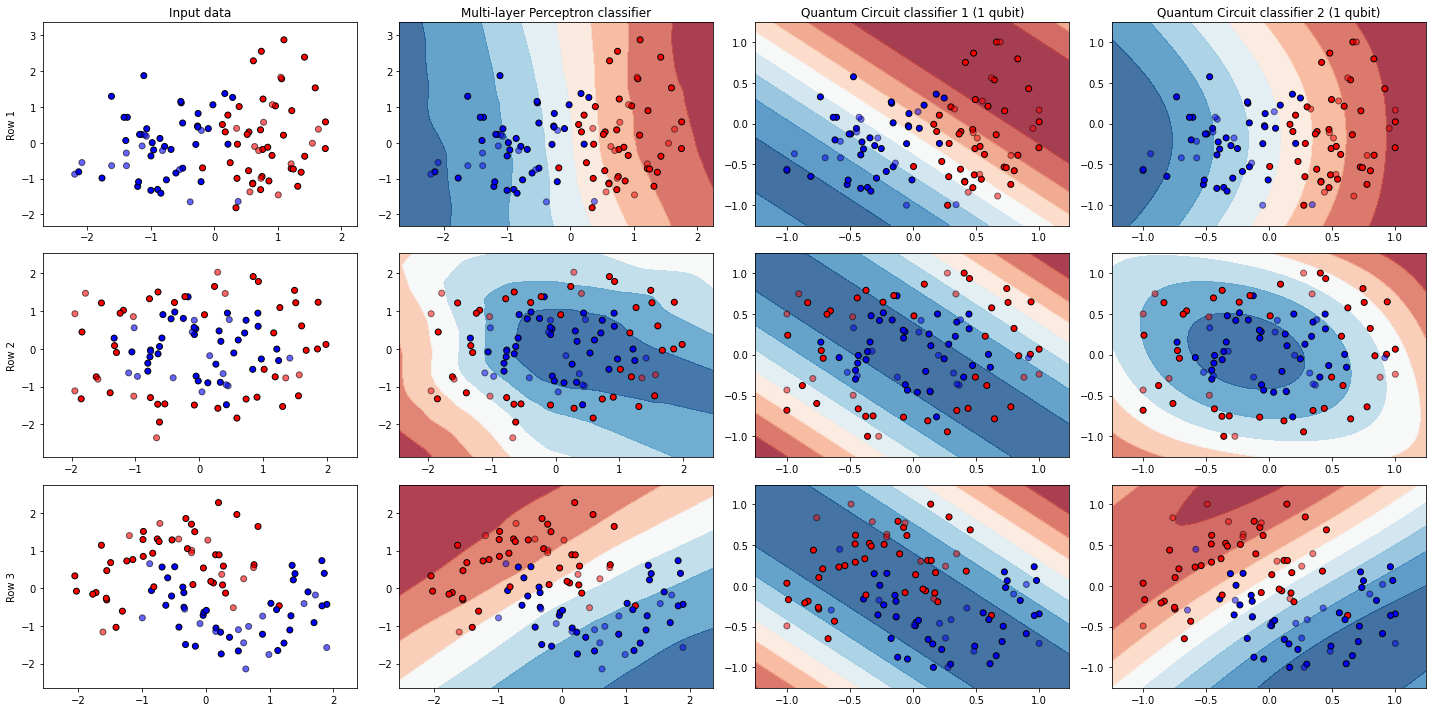

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.7182438 | Acc train: 0.5066667 | Acc val: 0.5200000 | Acc all: 0.5000000 
Iter:     2 | Cost: 1.6520072 | Acc train: 0.5066667 | Acc val: 0.5200000 | Acc all: 0.5000000 
Iter:     3 | Cost: 1.5831265 | Acc train: 0.5066667 | Acc val: 0.5200000 | Acc all: 0.5000000 
Iter:     4 | Cost: 1.4865770 | Acc train: 0.5066667 | Acc val: 0.5200000 | Acc all: 0.5000000 
Iter:     5 | Cost: 1.3586082 | Acc train: 0.5333333 | Acc val: 0.5200000 | Acc all: 0.5200000 
Iter:     6 | Cost: 1.2512446 | Acc train: 0.5600000 | Acc val: 0.6000000 | Acc all: 0.5500000 
Iter:     7 | Cost: 1.1500250 | Acc train: 0.5733333 | Acc val: 0.6000000 | Acc all: 0.5600000 
Iter:     8 | Cost: 1.0470461 | Acc train: 0.5866667 | Acc val: 0.6400000 | Acc all: 0.5800000 
Iter:     9 | Cost: 0.9560260 | Acc train: 0.6266667 | Acc val: 0.6800000 | Acc all: 0.6300000 
Iter:    10 | Cost: 0.8858672 | Acc train: 0.6400000 | Acc val: 0.7200000 | Acc all: 0.6400000 
Iter:    11 | Cost: 0.8222198 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.3825297 | Acc train: 0.5066667 | Acc val: 0.5600000 | Acc all: 0.5100000 
Iter:     2 | Cost: 1.3323759 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5100000 
Iter:     3 | Cost: 1.2741853 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5300000 
Iter:     4 | Cost: 1.2164346 | Acc train: 0.5200000 | Acc val: 0.6000000 | Acc all: 0.5400000 
Iter:     5 | Cost: 1.1455669 | Acc train: 0.5866667 | Acc val: 0.6000000 | Acc all: 0.5600000 
Iter:     6 | Cost: 1.0866516 | Acc train: 0.5866667 | Acc val: 0.6000000 | Acc all: 0.5800000 
Iter:     7 | Cost: 1.0404440 | Acc train: 0.5866667 | Acc val: 0.6800000 | Acc all: 0.5800000 
Iter:     8 | Cost: 0.9867098 | Acc train: 0.6133333 | Acc val: 0.6800000 | Acc all: 0.5900000 
Iter:     9 | Cost: 0.9413155 | Acc train: 0.6266667 | Acc val: 0.6800000 | Acc all: 0.6300000 
Iter:    10 | Cost: 0.9084497 | Acc train: 0.6533333 | Acc val: 0.7200000 | Acc all: 0.6400000 
Iter:    11 | Cost: 0.8728482 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.6758927 | Acc train: 0.4800000 | Acc val: 0.5600000 | Acc all: 0.5000000 
Iter:     2 | Cost: 1.6096479 | Acc train: 0.4800000 | Acc val: 0.6000000 | Acc all: 0.5000000 
Iter:     3 | Cost: 1.5482289 | Acc train: 0.4800000 | Acc val: 0.6000000 | Acc all: 0.5000000 
Iter:     4 | Cost: 1.4677833 | Acc train: 0.4800000 | Acc val: 0.6000000 | Acc all: 0.5000000 
Iter:     5 | Cost: 1.4013567 | Acc train: 0.4800000 | Acc val: 0.6000000 | Acc all: 0.5000000 
Iter:     6 | Cost: 1.3372966 | Acc train: 0.4933333 | Acc val: 0.6000000 | Acc all: 0.5100000 
Iter:     7 | Cost: 1.2635874 | Acc train: 0.4933333 | Acc val: 0.6000000 | Acc all: 0.5000000 
Iter:     8 | Cost: 1.1901451 | Acc train: 0.4933333 | Acc val: 0.6000000 | Acc all: 0.5100000 
Iter:     9 | Cost: 1.1278237 | Acc train: 0.5733333 | Acc val: 0.6000000 | Acc all: 0.5400000 
Iter:    10 | Cost: 1.0779398 | Acc train: 0.5733333 | Acc val: 0.5600000 | Acc all: 0.5700000 
Iter:    11 | Cost: 1.0430357 | Acc trai

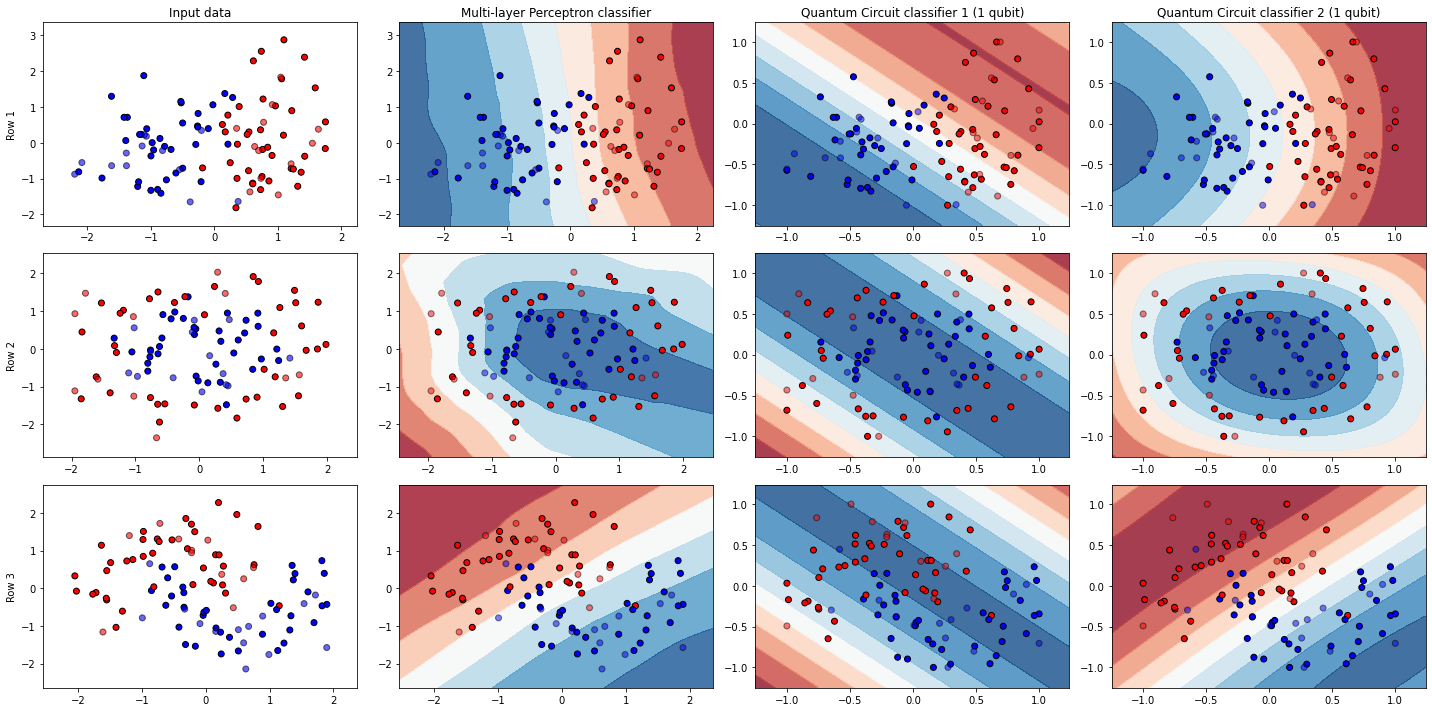

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.7202540 | Acc train: 0.5066667 | Acc val: 0.5200000 | Acc all: 0.5000000 
Iter:     2 | Cost: 1.6545481 | Acc train: 0.5066667 | Acc val: 0.5200000 | Acc all: 0.5000000 
Iter:     3 | Cost: 1.5842614 | Acc train: 0.5066667 | Acc val: 0.5200000 | Acc all: 0.5000000 
Iter:     4 | Cost: 1.4996155 | Acc train: 0.5066667 | Acc val: 0.5200000 | Acc all: 0.5000000 
Iter:     5 | Cost: 1.3903950 | Acc train: 0.5333333 | Acc val: 0.5200000 | Acc all: 0.5200000 
Iter:     6 | Cost: 1.2773623 | Acc train: 0.5600000 | Acc val: 0.6000000 | Acc all: 0.5500000 
Iter:     7 | Cost: 1.1640076 | Acc train: 0.5733333 | Acc val: 0.6000000 | Acc all: 0.5600000 
Iter:     8 | Cost: 1.0482277 | Acc train: 0.5866667 | Acc val: 0.6400000 | Acc all: 0.5800000 
Iter:     9 | Cost: 0.9327810 | Acc train: 0.6266667 | Acc val: 0.6800000 | Acc all: 0.6400000 
Iter:    10 | Cost: 0.8431391 | Acc train: 0.6266667 | Acc val: 0.7600000 | Acc all: 0.6500000 
Iter:    11 | Cost: 0.7713582 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.4072788 | Acc train: 0.4933333 | Acc val: 0.5600000 | Acc all: 0.5000000 
Iter:     2 | Cost: 1.3842611 | Acc train: 0.4933333 | Acc val: 0.5600000 | Acc all: 0.5000000 
Iter:     3 | Cost: 1.3374651 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5200000 
Iter:     4 | Cost: 1.2832993 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5300000 
Iter:     5 | Cost: 1.2324019 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5300000 
Iter:     6 | Cost: 1.1627012 | Acc train: 0.5600000 | Acc val: 0.6000000 | Acc all: 0.5600000 
Iter:     7 | Cost: 1.0953233 | Acc train: 0.5866667 | Acc val: 0.6000000 | Acc all: 0.5700000 
Iter:     8 | Cost: 1.0254132 | Acc train: 0.6000000 | Acc val: 0.6400000 | Acc all: 0.5900000 
Iter:     9 | Cost: 0.9695301 | Acc train: 0.6266667 | Acc val: 0.6800000 | Acc all: 0.6200000 
Iter:    10 | Cost: 0.9253146 | Acc train: 0.6400000 | Acc val: 0.7200000 | Acc all: 0.6300000 
Iter:    11 | Cost: 0.8910771 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.6865594 | Acc train: 0.4800000 | Acc val: 0.5600000 | Acc all: 0.5000000 
Iter:     2 | Cost: 1.6339922 | Acc train: 0.4800000 | Acc val: 0.6000000 | Acc all: 0.5000000 
Iter:     3 | Cost: 1.5827025 | Acc train: 0.4800000 | Acc val: 0.6000000 | Acc all: 0.5000000 
Iter:     4 | Cost: 1.5250341 | Acc train: 0.4800000 | Acc val: 0.6000000 | Acc all: 0.5100000 
Iter:     5 | Cost: 1.4411394 | Acc train: 0.4933333 | Acc val: 0.6000000 | Acc all: 0.5100000 
Iter:     6 | Cost: 1.3834267 | Acc train: 0.5066667 | Acc val: 0.6000000 | Acc all: 0.5200000 
Iter:     7 | Cost: 1.3394484 | Acc train: 0.5066667 | Acc val: 0.6000000 | Acc all: 0.5200000 
Iter:     8 | Cost: 1.2901236 | Acc train: 0.5733333 | Acc val: 0.6000000 | Acc all: 0.5300000 
Iter:     9 | Cost: 1.2477215 | Acc train: 0.5733333 | Acc val: 0.6000000 | Acc all: 0.5400000 
Iter:    10 | Cost: 1.2102699 | Acc train: 0.5600000 | Acc val: 0.5600000 | Acc all: 0.5700000 
Iter:    11 | Cost: 1.1659241 | Acc trai

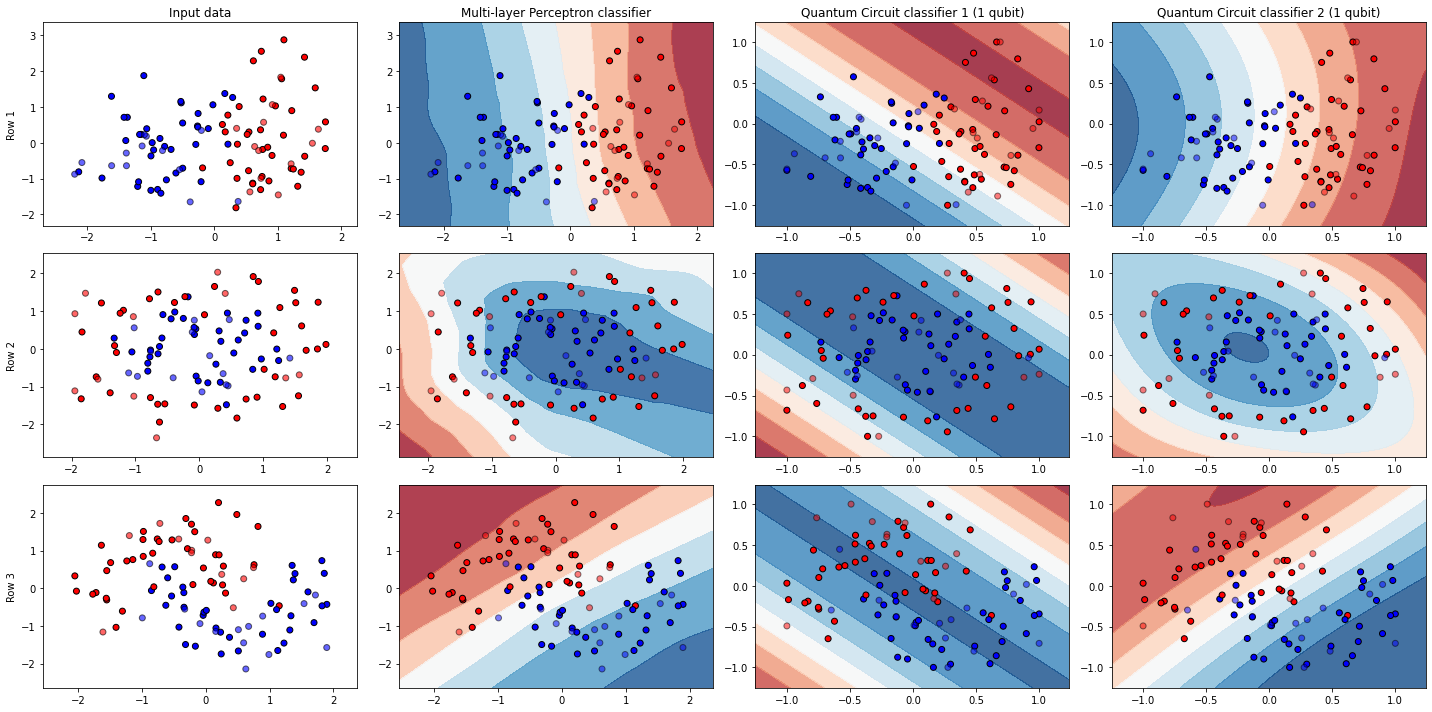

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.7452933 | Acc train: 0.5066667 | Acc val: 0.5200000 | Acc all: 0.5100000 
Iter:     2 | Cost: 1.7086220 | Acc train: 0.5066667 | Acc val: 0.5600000 | Acc all: 0.5100000 
Iter:     3 | Cost: 1.6524309 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5100000 
Iter:     4 | Cost: 1.5766217 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5100000 
Iter:     5 | Cost: 1.4732293 | Acc train: 0.5466667 | Acc val: 0.5600000 | Acc all: 0.5300000 
Iter:     6 | Cost: 1.3710925 | Acc train: 0.5466667 | Acc val: 0.5600000 | Acc all: 0.5400000 
Iter:     7 | Cost: 1.2497485 | Acc train: 0.5733333 | Acc val: 0.6400000 | Acc all: 0.5700000 
Iter:     8 | Cost: 1.1095765 | Acc train: 0.5866667 | Acc val: 0.6400000 | Acc all: 0.5800000 
Iter:     9 | Cost: 0.9849007 | Acc train: 0.6266667 | Acc val: 0.7200000 | Acc all: 0.6300000 
Iter:    10 | Cost: 0.8657229 | Acc train: 0.6400000 | Acc val: 0.7200000 | Acc all: 0.6400000 
Iter:    11 | Cost: 0.7750891 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.4005137 | Acc train: 0.4933333 | Acc val: 0.5600000 | Acc all: 0.5000000 
Iter:     2 | Cost: 1.3733616 | Acc train: 0.4933333 | Acc val: 0.5600000 | Acc all: 0.5000000 
Iter:     3 | Cost: 1.3142372 | Acc train: 0.5066667 | Acc val: 0.6000000 | Acc all: 0.5300000 
Iter:     4 | Cost: 1.2419806 | Acc train: 0.5200000 | Acc val: 0.6000000 | Acc all: 0.5400000 
Iter:     5 | Cost: 1.1603900 | Acc train: 0.5466667 | Acc val: 0.6000000 | Acc all: 0.5500000 
Iter:     6 | Cost: 1.0882307 | Acc train: 0.5600000 | Acc val: 0.6400000 | Acc all: 0.5500000 
Iter:     7 | Cost: 1.0203973 | Acc train: 0.6133333 | Acc val: 0.6400000 | Acc all: 0.6000000 
Iter:     8 | Cost: 0.9596047 | Acc train: 0.6400000 | Acc val: 0.6800000 | Acc all: 0.6300000 
Iter:     9 | Cost: 0.9184212 | Acc train: 0.6400000 | Acc val: 0.7600000 | Acc all: 0.6300000 
Iter:    10 | Cost: 0.8807738 | Acc train: 0.6533333 | Acc val: 0.7600000 | Acc all: 0.6800000 
Iter:    11 | Cost: 0.8515617 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.6806207 | Acc train: 0.4800000 | Acc val: 0.5600000 | Acc all: 0.5000000 
Iter:     2 | Cost: 1.6158431 | Acc train: 0.4800000 | Acc val: 0.6000000 | Acc all: 0.5000000 
Iter:     3 | Cost: 1.5434465 | Acc train: 0.4800000 | Acc val: 0.6000000 | Acc all: 0.5000000 
Iter:     4 | Cost: 1.4600892 | Acc train: 0.4800000 | Acc val: 0.6000000 | Acc all: 0.5000000 
Iter:     5 | Cost: 1.3710245 | Acc train: 0.4933333 | Acc val: 0.6000000 | Acc all: 0.5100000 
Iter:     6 | Cost: 1.2805969 | Acc train: 0.4933333 | Acc val: 0.6000000 | Acc all: 0.5100000 
Iter:     7 | Cost: 1.1986206 | Acc train: 0.5066667 | Acc val: 0.6000000 | Acc all: 0.5100000 
Iter:     8 | Cost: 1.1399637 | Acc train: 0.5466667 | Acc val: 0.6000000 | Acc all: 0.5200000 
Iter:     9 | Cost: 1.0972244 | Acc train: 0.5866667 | Acc val: 0.5600000 | Acc all: 0.6000000 
Iter:    10 | Cost: 1.0612656 | Acc train: 0.5600000 | Acc val: 0.5600000 | Acc all: 0.5700000 
Iter:    11 | Cost: 1.0378243 | Acc trai

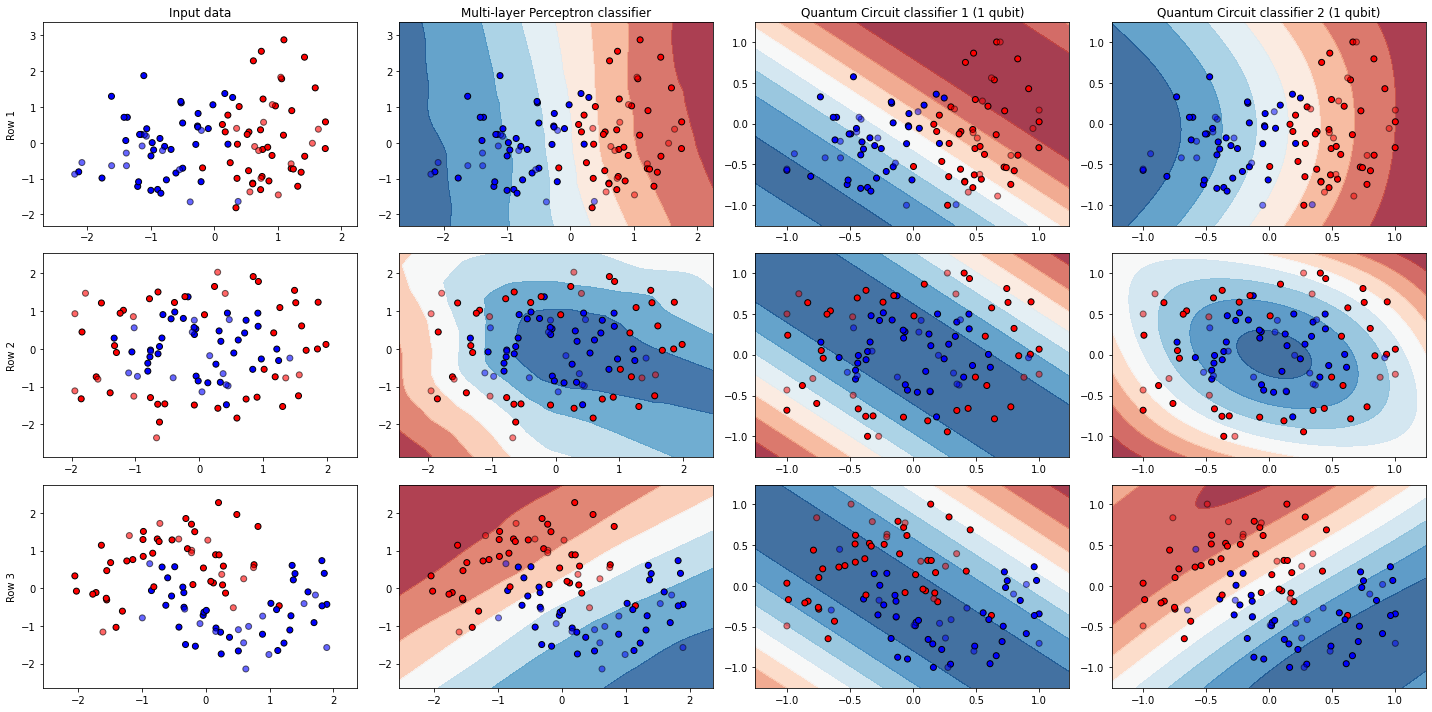

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.7129944 | Acc train: 0.5066667 | Acc val: 0.5200000 | Acc all: 0.5000000 
Iter:     2 | Cost: 1.6526325 | Acc train: 0.5066667 | Acc val: 0.5200000 | Acc all: 0.5100000 
Iter:     3 | Cost: 1.5661109 | Acc train: 0.5066667 | Acc val: 0.5200000 | Acc all: 0.5000000 
Iter:     4 | Cost: 1.4822059 | Acc train: 0.5333333 | Acc val: 0.5200000 | Acc all: 0.5200000 
Iter:     5 | Cost: 1.3779020 | Acc train: 0.5333333 | Acc val: 0.5200000 | Acc all: 0.5200000 
Iter:     6 | Cost: 1.2610096 | Acc train: 0.5466667 | Acc val: 0.6000000 | Acc all: 0.5400000 
Iter:     7 | Cost: 1.1595598 | Acc train: 0.5600000 | Acc val: 0.6000000 | Acc all: 0.5400000 
Iter:     8 | Cost: 1.0565854 | Acc train: 0.5733333 | Acc val: 0.6400000 | Acc all: 0.5600000 
Iter:     9 | Cost: 0.9777725 | Acc train: 0.6133333 | Acc val: 0.6800000 | Acc all: 0.6000000 
Iter:    10 | Cost: 0.9171964 | Acc train: 0.6133333 | Acc val: 0.6800000 | Acc all: 0.6100000 
Iter:    11 | Cost: 0.8689690 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.3639395 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5100000 
Iter:     2 | Cost: 1.3170766 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5200000 
Iter:     3 | Cost: 1.2504787 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5200000 
Iter:     4 | Cost: 1.1691117 | Acc train: 0.5600000 | Acc val: 0.6000000 | Acc all: 0.5700000 
Iter:     5 | Cost: 1.0868937 | Acc train: 0.5866667 | Acc val: 0.6400000 | Acc all: 0.5700000 
Iter:     6 | Cost: 1.0226743 | Acc train: 0.6000000 | Acc val: 0.6400000 | Acc all: 0.5900000 
Iter:     7 | Cost: 0.9668176 | Acc train: 0.6266667 | Acc val: 0.6800000 | Acc all: 0.6200000 
Iter:     8 | Cost: 0.9184354 | Acc train: 0.6400000 | Acc val: 0.7200000 | Acc all: 0.6300000 
Iter:     9 | Cost: 0.8868666 | Acc train: 0.6666667 | Acc val: 0.7600000 | Acc all: 0.6700000 
Iter:    10 | Cost: 0.8633779 | Acc train: 0.6933333 | Acc val: 0.7600000 | Acc all: 0.6900000 
Iter:    11 | Cost: 0.8459037 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.6738421 | Acc train: 0.4800000 | Acc val: 0.5600000 | Acc all: 0.5000000 
Iter:     2 | Cost: 1.6120977 | Acc train: 0.4800000 | Acc val: 0.6000000 | Acc all: 0.5000000 
Iter:     3 | Cost: 1.5465454 | Acc train: 0.4800000 | Acc val: 0.6000000 | Acc all: 0.5000000 
Iter:     4 | Cost: 1.4645625 | Acc train: 0.4800000 | Acc val: 0.6000000 | Acc all: 0.5000000 
Iter:     5 | Cost: 1.3735872 | Acc train: 0.4800000 | Acc val: 0.6000000 | Acc all: 0.5000000 
Iter:     6 | Cost: 1.3035801 | Acc train: 0.4933333 | Acc val: 0.6000000 | Acc all: 0.5100000 
Iter:     7 | Cost: 1.2389554 | Acc train: 0.4933333 | Acc val: 0.6000000 | Acc all: 0.5000000 
Iter:     8 | Cost: 1.1668454 | Acc train: 0.5333333 | Acc val: 0.6000000 | Acc all: 0.5300000 
Iter:     9 | Cost: 1.1103272 | Acc train: 0.5200000 | Acc val: 0.6000000 | Acc all: 0.5300000 
Iter:    10 | Cost: 1.0685876 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5100000 
Iter:    11 | Cost: 1.0369095 | Acc trai

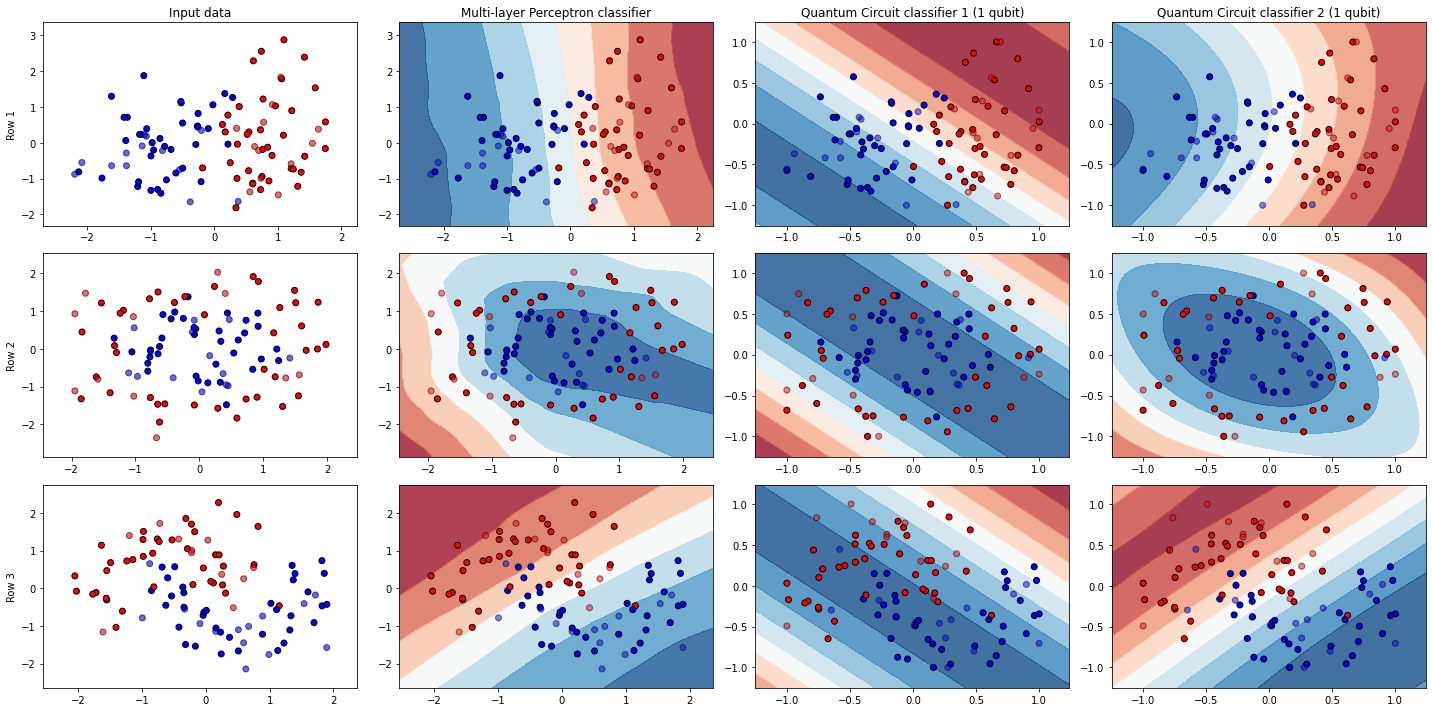

scores: [[[0.96 0.52 0.8 ]
  [0.96 0.52 0.8 ]
  [0.96 0.52 0.8 ]
  [0.96 0.52 0.8 ]
  [0.96 0.52 0.8 ]
  [0.96 0.52 0.8 ]
  [0.96 0.52 0.8 ]
  [0.96 0.52 0.8 ]
  [0.96 0.52 0.8 ]
  [0.96 0.52 0.8 ]
  [0.96 0.52 0.8 ]
  [0.96 0.52 0.8 ]
  [0.96 0.52 0.8 ]]

 [[0.84 0.72 0.56]
  [0.84 0.44 0.48]
  [0.88 0.68 0.6 ]
  [0.88 0.76 0.44]
  [0.84 0.72 0.44]
  [0.92 0.68 0.72]
  [0.88 0.68 0.52]
  [0.84 0.72 0.44]
  [0.88 0.76 0.56]
  [0.88 0.72 0.52]
  [0.92 0.68 0.48]
  [0.84 0.68 0.6 ]
  [0.84 0.72 0.76]]

 [[0.88 0.8  0.84]
  [0.92 0.8  0.8 ]
  [0.92 0.8  0.8 ]
  [0.96 0.96 0.84]
  [0.88 0.8  0.8 ]
  [0.96 0.44 0.8 ]
  [0.88 0.48 0.84]
  [0.88 0.8  0.84]
  [0.96 0.76 0.84]
  [0.92 0.8  0.84]
  [0.84 0.88 0.84]
  [0.96 0.88 0.84]
  [0.92 0.88 0.84]]]


In [5]:
halfPi = pi/2
# h = 0.02  # step size in the mesh
h = 0.03  # step size in the mesh
n_samples = 100

names = [
    "Multi-layer Perceptron classifier",
    # "Linear SVM",
    # "Quantum classifier circuit 1",
    "Quantum Circuit classifier 1 (1 qubit)",
    "Quantum Circuit classifier 2 (1 qubit)",
]

classifiers = [
  MLPClassifier(random_state=1, max_iter=max_iterations, 
                    solver="sgd", nesterovs_momentum=True),
  # SVC(kernel="linear", C=0.025),
  # [vc_quantum, vc_classifier_1, init_weights_1, circuit_1],
  [vc_quantum, vc_classifier_2, init_weights_2, circuit_2],
  [vc_quantum, vc_classifier_3, init_weights_3, circuit_3],
]

X, y = make_classification(
    n_samples=n_samples,
    n_features=2, n_redundant=0, n_informative=2, random_state=1, n_clusters_per_class=1
)
rng = numpy.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)
linearly_separable = (X, y)

datasets = [
    linearly_separable,
    make_circles(n_samples=n_samples, noise=0.2, factor=0.5, random_state=1),
    make_moons(n_samples=n_samples, noise=0.3, random_state=0),
]

# initalize scores array
scores = np.zeros(shape=(len(classifiers),loop_count,len(datasets)))

#############
# Main Loop #
#############
for l_count in range(loop_count):
  figure = plt.figure(figsize=(20, 10))
  # Figure: set white background
  figure.patch.set_facecolor('xkcd:white')

  i = 1
  # iterate over datasets
  for ds_cnt, ds in enumerate(datasets):
      # preprocess dataset, split into training and test part
      X, y = ds
      
      X = StandardScaler().fit_transform(X)
      X_train, X_test, y_train, y_test = train_test_split(
          X, y, test_size=0.25, random_state=1
      )
      x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
      y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
      xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
      
      # scale data for quantum data
      y_train_quantum = np.where(y_train==0, y_train-1, y_train)
      y_test_quantum = np.where(y_test==0, y_test-1, y_test)
      y_quantum = np.where(y==0, y-1, y)
      
      scale_value=1
      X_scaled = MinMaxScaler(feature_range=(-scale_value,scale_value), copy=True).fit_transform(X)
      X_train_scaled = MinMaxScaler(feature_range=(-scale_value,scale_value), copy=True).fit_transform(X_train)
      X_test_scaled = MinMaxScaler(feature_range=(-scale_value,scale_value), copy=True).fit_transform(X_test)

      x_min_scaled, x_max_scaled = X_scaled[:, 0].min() - 0.25, X_scaled[:, 0].max() + 0.25
      y_min_scaled, y_max_scaled = X_scaled[:, 1].min() - 0.25, X_scaled[:, 1].max() + 0.25
      xx_scaled, yy_scaled = np.meshgrid(np.arange(x_min_scaled, x_max_scaled, h), np.arange(y_min_scaled, y_max_scaled, h))

      # just plot the dataset first
      cm = plt.cm.RdBu
      cm_bright = ListedColormap(["#FF0000", "#0000FF"])
      ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
      if ds_cnt == 0:
          ax.set_title("Input data")
      ax.set(ylabel='Row ' + str(ds_cnt+1))
      # Plot the training points
      ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k")
      # Plot the testing points
      ax.scatter(
          X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6, edgecolors="k"
      )
      ax.set_xlim(xx.min(), xx.max())
      ax.set_ylim(yy.min(), yy.max())
      #ax.set_xticks(())
      #ax.set_yticks(())
      i += 1

      classifier_count=0
      # iterate over classifiers
      for name, clf in zip(names, classifiers):
          ax = plt.subplot(len(datasets), len(classifiers) + 1, i)

          if 'Quantum' in name:
            # Quantum circuit #
            vars, score = clf[0](clf[1], clf[2], X_train_scaled, X_test_scaled, X_scaled, y_train_quantum, y_test_quantum, y_quantum)
            Z = np.array(
              [clf[1](vars, f) for f in np.c_[xx_scaled.ravel(), yy_scaled.ravel()]]
            )

            # Put the result into a color plot
            Z = Z.reshape(xx_scaled.shape)
            ax.contourf(xx_scaled, yy_scaled, Z, cmap=cm, alpha=0.8)
            
            # Plot the training points
            ax.scatter(
                X_train_scaled[:, 0], X_train_scaled[:, 1], c=y_train_quantum, cmap=cm_bright, edgecolors="k"
            )
            # Plot the testing points
            ax.scatter(
                X_test_scaled[:, 0],
                X_test_scaled[:, 1],
                c=y_test_quantum,
                cmap=cm_bright,
                edgecolors="k",
                alpha=0.5,
            )

            ax.set_xlim(xx_scaled.min(), xx_scaled.max())
            ax.set_ylim(yy_scaled.min(), yy_scaled.max())
            
            # print scores
            # ax.text(
            #   xx_scaled.max() - 0.15,
            #   yy_scaled.min() + 0.15,
            #   ("Score: %.2f" % score).lstrip("0"),
            #   size=15,
            #   horizontalalignment="right",
            # )
            
          else:
            # Classical circuits #
            clf.fit(X_train, y_train)
            score = clf.score(X_test, y_test)

            # Plot the decision boundary. For that, we will assign a color to each
            # point in the mesh [x_min, x_max]x[y_min, y_max].
            if hasattr(clf, "decision_function"):
                Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
            else:
                Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

            # Put the result into a color plot
            Z = Z.reshape(xx.shape)
            ax.contourf(xx, yy, Z, cmap=cm, alpha=0.8)
                
            # Plot the training points
            ax.scatter(
                X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k"
            )
            # Plot the testing points
            ax.scatter(
                X_test[:, 0],
                X_test[:, 1],
                c=y_test,
                cmap=cm_bright,
                edgecolors="k",
                alpha=0.5,
            )

            ax.set_xlim(xx.min(), xx.max())
            ax.set_ylim(yy.min(), yy.max())

            # print scores
            # ax.text(
            #   xx.max() - 0.3,
            #   yy.min() + 0.3,
            #   ("Score: %.2f" % score).lstrip("0"),
            #   size=15,
            #   horizontalalignment="right",
            # )
          
          scores[classifier_count][l_count][ds_cnt] = score
          # ax.set_xticks(())
          # ax.set_yticks(())
          if ds_cnt == 0:
              ax.set_title(name)
          i += 1
          classifier_count += 1

  plt.tight_layout()
  plt.show()

print("scores:", scores)

In [6]:
for name, clf in zip(names, classifiers):
    if 'Quantum' in name:
      print(name)
      print(clf[3].draw())


Quantum Circuit classifier 1 (1 qubit)
 0: ──RY(1.24)──Rot(-0.00431, 0.201, 0.0044)──RY(1.24)──Rot(0.0014, 0.201, 0.0171)──┤ ⟨Z⟩ 

Quantum Circuit classifier 2 (1 qubit)
 0: ──RY(1.24)──Rot(0.058, -0.463, 1.09)──RX(1.24)──Rot(-1.37, -1.24, 0.00129)──┤ ⟨Z⟩ 



C:\Users\zero\anaconda3\lib\site-packages\pennylane\qnode.py:838: UserWarning: The QNode.draw method has been deprecated. Please use the qml.draw(qnode)(*args) function instead.
  warnings.warn(
